In [1]:
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm

print("Hi")

Hi


In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.util import ngrams
import spacy
import re

In [3]:
from sklearn.metrics import f1_score, jaccard_score, classification_report

In [4]:
# Load data
train = pd.read_csv('../public_data_test/track_a/train/eng.csv')
val = pd.read_csv('../public_data_test/track_a/dev/eng.csv')
test = pd.read_csv('../public_data_test/track_a/test/eng.csv')

# Define emotions and mapping (model's labels to our labels)
emotions = ['joy', 'sadness', 'surprise', 'fear', 'anger']
emotion_mapping = {
    'joy': 'joy',
    'sadness': 'sadness',
    'surprise': 'surprise',
    'fear': 'fear',
    'anger': 'anger',
    'love': None  # We'll ignore this emotion as it's not in our target set
}

In [5]:
# Preprocessing Config
config = {
    'sep_pn': True, 
    'rm_pn': False, 
    'apply_lemmatization': True, 
    'apply_stemming': True, 
    'add_bigrams': True, 
    'rm_sw': False
}

In [49]:
# Load the pre-trained model and tokenizer
model_name = "bhadresh-savani/bert-base-uncased-emotion"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [7]:
emolex_path = "../NRC-Emotion-Lexicon/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt"

In [8]:
def load_emolex(emolex_path):
    emolex = pd.read_csv(emolex_path, sep='\t', header=None, names=["Word", "Emotion", "Association"])
    # Filter to only include our target emotions
    emolex = emolex[emolex['Emotion'].isin(emotions)]
    
    emotion_dict = {}
    for _, row in emolex.iterrows():
        if row["Association"] == 1:  # Only positive associations
            word = row["Word"].lower()  # Convert to lowercase
            emotion = row["Emotion"].lower()
            if word not in emotion_dict:
                emotion_dict[word] = []
            emotion_dict[word].append(emotion)
    
    print(f"Loaded {len(emotion_dict)} words from EmoLex")
    return emotion_dict

emotion_dict = load_emolex(emolex_path)

Loaded 3155 words from EmoLex


In [61]:
nlp = spacy.load("en_core_web_sm")

# Initialize emotion_matches globally before preprocessing
emotion_matches = {emotion: 0 for emotion in emotions}

for emotion in emotions:
    emotion_words = [word for word, emots in emotion_dict.items() if emotion in emots]
    print(f"\n{emotion} words in lexicon: {len(emotion_words)}")
    print("Sample words:", emotion_words[:5])

# During preprocessing
def pre_process(text, config, target_emotion, emotion_dict):
    global emotion_matches  # Reference the global variable
    
    original_text = text  # Save original text for EmoLex matching

    # First do EmoLex matching on original text
    emolex_words = []
    if target_emotion and emotion_dict:
        # Convert text to lowercase for matching
        text_lower = original_text.lower()
        # Find words that appear in both text and emotion lexicon
        text_words = set(text_lower.split())
        emolex_words = [word for word in text_words 
                       if word in emotion_dict 
                       and target_emotion in emotion_dict[word]]
        # print(target_emotion)
        # for word in text_words:
        #     if word in emotion_dict and target_emotion in emotion_dict[word]:
                # print("MATCH")
                # print(emotion_dict[word])
                # print(f"{word} and {emotion_dict[word]} is a match")
            # else:
            #     print(word)
        
        if emolex_words:
            emotion_matches[target_emotion] += 1
    
    emolex_str = " ".join(emolex_words)

    text = f"{original_text} [SEP] {emolex_str}"

    def separate_punctuation(text):
        text = re.sub(r"(\w)([.,;:!?'\"”\)])", r"\1 \2", text)
        text = re.sub(r"([.,;:!?'\"“\(\)])(\w)", r"\1 \2", text)
        return text

    # def remove_punctuation(text):
    #     text = re.sub(r"[.,;:!?'\"“”\(\)]", "", text)
    #     return text

    # def tokenize_text(text):
    #     encoded_input = tokenizer(text, return_tensors='pt', add_special_tokens=True, truncation=True, padding=True, max_length=512)
    #     input_ids = encoded_input['input_ids']
    #     token_type_ids = encoded_input['token_type_ids']
    #     attention_mask = encoded_input['attention_mask']
    #     print(input_ids)
    #     print(token_type_ids)
    #     print(attention_mask)
    #     return encoded_input

    # def apply_stemming(tokens):
    #     stemmer = PorterStemmer()
    #     return [stemmer.stem(token) for token in tokens]

    # def apply_lemmatization(tokens):
    #     lemmatizer = WordNetLemmatizer()
    #     return [lemmatizer.lemmatize(token) for token in tokens]

    # def generate_ngrams_from_tokens(tokens, n):
    #     return [" ".join(gram) for gram in ngrams(tokens, n)]

    # Apply config options
    if config['sep_pn'] and not config['rm_pn']:
        text = separate_punctuation(text)
    # if config['rm_pn'] and not config['sep_pn']:
    #     text = remove_punctuation(text)

    # if emolex_words:
    #     text = f"{text} [SEP] {emolex_words}"
    # else:
    #     text = f"{text} [SEP]"

    # tokens = tokenize_text(text)
    # if config['apply_stemming']:
    #     tokens = apply_stemming(tokens)
    # if config['apply_lemmatization']:
    #     tokens = apply_lemmatization(tokens)
    # if config['add_bigrams']:
    #     tokens += generate_ngrams_from_tokens(tokens, 2)
    # if config['rm_sw']:
    #     stop_words = set(stopwords.words('english'))
    #     tokens = [word for word in tokens if word.lower() not in stop_words]
    # print(f"tokens: {tokens}")
    # processed_text = " ".join(tokens)
    # print(f"processed_text: {processed_text}")

    # Finally, append EmoLex words if found
    # if emolex_words:
    #     processed_text = f"{processed_text} [SEP] {' '.join(emolex_words)}"
    # else:
    #     processed_text = f"{processed_text} [SEP]"
    
    return text 


joy words in lexicon: 687
Sample words: ['absolution', 'abundance', 'abundant', 'accolade', 'accompaniment']

sadness words in lexicon: 1187
Sample words: ['abandon', 'abandoned', 'abandonment', 'abduction', 'abortion']

surprise words in lexicon: 532
Sample words: ['abandonment', 'abduction', 'abrupt', 'accident', 'accidental']

fear words in lexicon: 1474
Sample words: ['abandon', 'abandoned', 'abandonment', 'abduction', 'abhor']

anger words in lexicon: 1245
Sample words: ['abandoned', 'abandonment', 'abhor', 'abhorrent', 'abolish']


In [87]:
# Reset emotion_matches before processing dataset
def preprocess_dataset_with_emotions(dataset, emotions, config, emotion_dict, split_name):
    global emotion_matches
    emotion_matches = {emotion: 0 for emotion in emotions}  # Reset counters
    
    augmented_data = {}
    
    # Process for each emotion
    for emotion in emotions:
        print(f"\nProcessing {emotion}:")
        texts = []
        # Process each text one at a time from the dataset 
        for text in tqdm(dataset):
            processed = pre_process(text, config, target_emotion=emotion, emotion_dict=emotion_dict)
            texts.append(processed)
            
        # Count how many texts contain emotion-specific words
        emotion_word_count = sum(1 for text in texts if '[SEP]' in text and not text.endswith('[SEP]'))
        print(f"Texts with {emotion}-specific words: {emotion_matches[emotion]}/{len(texts)}")
        
        augmented_data[emotion] = texts
        # print(f"augmented_data[emotion]: {augmented_data[emotion]}")
        
    # After preprocessing
    print(f"Emotion word matches in {split_name} data:")
    for emotion in emotions:
        print(f"{emotion}: {emotion_matches[emotion]} texts")
    

    return augmented_data

X_train = preprocess_dataset_with_emotions(train["text"], emotions, config, emotion_dict, "train")
X_val = preprocess_dataset_with_emotions(val["text"], emotions, config, emotion_dict, "val")
X_test = preprocess_dataset_with_emotions(test["text"], emotions, config, emotion_dict, "test")

# Fit the vectorizer on the combined training data
# vectorizer = CountVectorizer()
# vectorizer.fit(train_augmented['joy'] + train_augmented['sadness'] + train_augmented['surprise'] + train_augmented['fear'] + train_augmented['anger'])

# Transform each emotion separately
# X_train = {emotion: np.array(train_augmented[emotion]) for emotion in emotions}
# print(X_train.shape)
# X_val = {emotion: np.array(val_augmented[emotion]) for emotion in emotions}
# print(X_val.shape)
# X_test = {emotion: np.array(test_augmented[emotion]) for emotion in emotions}
# print(X_test.shape)
# Directly use the pre-processed text data
# X_train = {emotion: train_augmented[emotion] for emotion in emotions}
# X_val = {emotion: val_augmented[emotion] for emotion in emotions}
# X_test = {emotion: test_augmented[emotion] for emotion in emotions}
# Convert lists to NumPy arrays for each emotion
# X_train = {emotion: np.array(train_augmented[emotion]) for emotion in emotions}
# X_val = {emotion: np.array(val_augmented[emotion]) for emotion in emotions}
# X_test = {emotion: np.array(test_augmented[emotion]) for emotion in emotions}

print(X_train['anger'])

# Print the shape of each array for each emotion
# for emotion in emotions:
#     print(f"Shape of X_train[{emotion}]:", np.array(X_train[emotion]).shape)
#     print(f"Shape of X_val[{emotion}]:", np.array(X_val[emotion]).shape)
#     print(f"Shape of X_test[{emotion}]:", np.array(X_test[emotion]).shape)

# for emotion in emotions:
#     print(f"Processing emotion: {emotion}")

#     print(f"Sample data for {emotion}: {X_train[emotion][:5]}")


Processing joy:


100%|██████████| 2768/2768 [00:00<00:00, 43918.42it/s]


Texts with joy-specific words: 461/2768

Processing sadness:


100%|██████████| 2768/2768 [00:00<00:00, 52397.57it/s]


Texts with sadness-specific words: 569/2768

Processing surprise:


100%|██████████| 2768/2768 [00:00<00:00, 50248.80it/s]


Texts with surprise-specific words: 318/2768

Processing fear:


100%|██████████| 2768/2768 [00:00<00:00, 49530.22it/s]


Texts with fear-specific words: 520/2768

Processing anger:


100%|██████████| 2768/2768 [00:00<00:00, 42450.82it/s]


Texts with anger-specific words: 463/2768
Emotion word matches in train data:
joy: 461 texts
sadness: 569 texts
surprise: 318 texts
fear: 520 texts
anger: 463 texts

Processing joy:


100%|██████████| 116/116 [00:00<00:00, 57092.15it/s]


Texts with joy-specific words: 19/116

Processing sadness:


100%|██████████| 116/116 [00:00<00:00, 43592.80it/s]


Texts with sadness-specific words: 22/116

Processing surprise:


100%|██████████| 116/116 [00:00<00:00, 45029.09it/s]


Texts with surprise-specific words: 15/116

Processing fear:


100%|██████████| 116/116 [00:00<00:00, 42776.44it/s]


Texts with fear-specific words: 21/116

Processing anger:


100%|██████████| 116/116 [00:00<00:00, 57824.97it/s]


Texts with anger-specific words: 17/116
Emotion word matches in val data:
joy: 19 texts
sadness: 22 texts
surprise: 15 texts
fear: 21 texts
anger: 17 texts

Processing joy:


100%|██████████| 2767/2767 [00:00<00:00, 50868.46it/s]


Texts with joy-specific words: 453/2767

Processing sadness:


100%|██████████| 2767/2767 [00:00<00:00, 58419.90it/s]


Texts with sadness-specific words: 537/2767

Processing surprise:


100%|██████████| 2767/2767 [00:00<00:00, 54951.72it/s]


Texts with surprise-specific words: 349/2767

Processing fear:


100%|██████████| 2767/2767 [00:00<00:00, 46523.61it/s]


Texts with fear-specific words: 531/2767

Processing anger:


100%|██████████| 2767/2767 [00:00<00:00, 47229.81it/s]


Texts with anger-specific words: 438/2767
Emotion word matches in test data:
joy: 453 texts
sadness: 537 texts
surprise: 349 texts
fear: 531 texts
anger: 438 texts
['Colorado , middle of nowhere . [SEP] ', 'This involved swimming a pretty large lake that was over my head . [SEP] ', 'It was one of my most shameful experiences . [SEP] ', 'After all , I had vegetables coming out my ears all for the benefit of the young prince . [SEP] ', 'Then the screaming started . [SEP] screaming', "They don ' t fear death , and it seems they believe in reincarnation . [SEP] fear", 'You know what happens when I get one of these stupid ideas in my head . [SEP] ', 'My stomach even started giving me fits . [SEP] ', "Well , as we ' re bowling , my dinner began to not sit well with me , and I had to run to the bathroom . [SEP] ", 'Hondas are notoriously great cars for long trips for their dependability and great gas mileage . [SEP] ', "It ' s his reflection . [SEP] ", "not mine , and not that horrible , but 

In [88]:
# Create the emotion classifier pipeline
classifier = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    return_all_scores=True,
    device=0 if torch.cuda.is_available() else -1  # Use GPU if available
)

Device set to use cpu
/Users/angwang/miniforge3/lib/python3.12/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [89]:
def get_predictions_batch(texts, batch_size=32):
    """
    Get predictions for a list of texts in batches
    """
    all_predictions = []
    
    for i in tqdm(range(0, len(texts), batch_size), desc="Predicting"):
        batch_texts = texts[i:i + batch_size]
        predictions = classifier(batch_texts)
        all_predictions.extend(predictions)
    
    return all_predictions

In [81]:
def format_predictions(predictions, emotion_mapping):
    """
    Convert raw predictions to the required format
    """
    formatted_preds = []
    for pred in predictions:
        # Create a dictionary of emotion scores
        scores = {p['label']: p['score'] for p in pred}
        # Map to our required emotions and format
        row = [scores.get(emotion_mapping.get(e, e), 0) for e in emotions]
        formatted_preds.append(row)
    
    return np.array(formatted_preds)

In [82]:
# Convert labels to numpy arrays
y_train = train[emotions].values
y_val = val[emotions].values
y_test = test[emotions].values

In [90]:
for emotion in emotions:
    print(f"{emotion}: {np.array(X_train[emotion]).shape}")
    print(f"{emotion}: {np.array(X_val[emotion]).shape}")
    print(f"{emotion}: {np.array(X_test[emotion]).shape}")

joy: (2768,)
joy: (116,)
joy: (2767,)
sadness: (2768,)
sadness: (116,)
sadness: (2767,)
surprise: (2768,)
surprise: (116,)
surprise: (2767,)
fear: (2768,)
fear: (116,)
fear: (2767,)
anger: (2768,)
anger: (116,)
anger: (2767,)


### Using X_train directly into BERT, since it is in text form

Can also try using X_train with a vectorizer and then combining the resulting features with BERT features extracted from the raw text

In [91]:
X_train

{'joy': ['Colorado , middle of nowhere . [SEP] ',
  'This involved swimming a pretty large lake that was over my head . [SEP] pretty',
  'It was one of my most shameful experiences . [SEP] ',
  'After all , I had vegetables coming out my ears all for the benefit of the young prince . [SEP] ',
  'Then the screaming started . [SEP] ',
  "They don ' t fear death , and it seems they believe in reincarnation . [SEP] ",
  'You know what happens when I get one of these stupid ideas in my head . [SEP] ',
  'My stomach even started giving me fits . [SEP] ',
  "Well , as we ' re bowling , my dinner began to not sit well with me , and I had to run to the bathroom . [SEP] ",
  'Hondas are notoriously great cars for long trips for their dependability and great gas mileage . [SEP] ',
  "It ' s his reflection . [SEP] ",
  "not mine , and not that horrible , but i was browsing the personnel files last week and noticed that my boss ' birthday had occurred 3 days prior . [SEP] birthday",
  "i pushed sta

In [93]:
# Get BERT embeddings for training data
# print("Getting training BERT embeddings...")
# train_raw_preds = get_predictions_batch(X_train)
# train_bert_features = format_predictions(train_raw_preds, emotion_mapping)
# print(train_bert_features.shape)

# print("Getting validation BERT embeddings...")
# val_raw_preds = get_predictions_batch(X_val)
# val_bert_features = format_predictions(val_raw_preds, emotion_mapping)
# print(val_bert_features.shape)

# print("Getting test BERT embeddings...")
# test_raw_preds = get_predictions_batch(X_test)
# test_bert_features = format_predictions(test_raw_preds, emotion_mapping)
# print(test_bert_features.shape)

# Dictionary to store BERT features for each emotion
all_train_bert_features = {}

for emotion, texts_array in X_train.items():
    print(f"Getting BERT embeddings for {emotion}...")
    
    # Convert the NumPy array to a list
    # texts_list = texts_array.tolist()
    
    # Get predictions for the current emotion
    train_raw_preds = get_predictions_batch(texts_array)
    
    # Format predictions to get BERT features
    train_bert_features = format_predictions(train_raw_preds, emotion_mapping)
    
    # Store the BERT features in the dictionary
    all_train_bert_features[emotion] = train_bert_features
    
    print(f"{emotion} BERT features shape:", train_bert_features.shape)

all_val_bert_features = {}

for emotion, texts_array in X_val.items():
    # texts_list = texts_array.tolist()
    val_raw_preds = get_predictions_batch(texts_array)
    val_bert_features = format_predictions(val_raw_preds, emotion_mapping)
    all_val_bert_features[emotion] = val_bert_features
    print(f"{emotion} BERT features shape:", val_bert_features.shape)

all_test_bert_features = {}

for emotion, texts_array in X_test.items():
    # texts_list = texts_array.tolist()
    test_raw_preds = get_predictions_batch(texts_array)
    test_bert_features = format_predictions(test_raw_preds, emotion_mapping)
    all_test_bert_features[emotion] = test_bert_features
    print(f"{emotion} BERT features shape:", test_bert_features.shape)

# Get POS features
# print("Extracting POS features...")
# train_pos_tags = extract_pos_tags(train["text"])
# val_pos_tags = extract_pos_tags(val["text"])
# test_pos_tags = extract_pos_tags(test["text"])

# # POS Encoding
# max_length = max(
#     max(len(tags) for tags in train_pos_tags),
#     max(len(tags) for tags in val_pos_tags),
#     max(len(tags) for tags in test_pos_tags)
# )
# train_pos_tags = [tags + ['PAD'] * (max_length - len(tags)) for tags in train_pos_tags]
# val_pos_tags = [tags + ['PAD'] * (max_length - len(tags)) for tags in val_pos_tags]
# test_pos_tags = [tags + ['PAD'] * (max_length - len(tags)) for tags in test_pos_tags]

# encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
# train_pos_encoded = encoder.fit_transform(train_pos_tags)
# val_pos_encoded = encoder.transform(val_pos_tags)
# test_pos_encoded = encoder.transform(test_pos_tags)

Getting BERT embeddings for joy...


Predicting: 100%|██████████| 87/87 [03:43<00:00,  2.57s/it]


joy BERT features shape: (2768, 5)
Getting BERT embeddings for sadness...


Predicting: 100%|██████████| 87/87 [03:27<00:00,  2.38s/it]


sadness BERT features shape: (2768, 5)
Getting BERT embeddings for surprise...


Predicting: 100%|██████████| 87/87 [03:05<00:00,  2.13s/it]


surprise BERT features shape: (2768, 5)
Getting BERT embeddings for fear...


Predicting: 100%|██████████| 87/87 [04:26<00:00,  3.06s/it]


fear BERT features shape: (2768, 5)
Getting BERT embeddings for anger...


Predicting: 100%|██████████| 87/87 [03:58<00:00,  2.74s/it]


anger BERT features shape: (2768, 5)


Predicting: 100%|██████████| 4/4 [00:09<00:00,  2.35s/it]


joy BERT features shape: (116, 5)


Predicting: 100%|██████████| 4/4 [00:11<00:00,  2.93s/it]


sadness BERT features shape: (116, 5)


Predicting: 100%|██████████| 4/4 [00:10<00:00,  2.74s/it]


surprise BERT features shape: (116, 5)


Predicting: 100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


fear BERT features shape: (116, 5)


Predicting: 100%|██████████| 4/4 [00:13<00:00,  3.31s/it]


anger BERT features shape: (116, 5)


Predicting: 100%|██████████| 87/87 [04:10<00:00,  2.87s/it]


joy BERT features shape: (2767, 5)


Predicting: 100%|██████████| 87/87 [03:33<00:00,  2.45s/it]


sadness BERT features shape: (2767, 5)


Predicting: 100%|██████████| 87/87 [42:00<00:00, 28.97s/it]   


surprise BERT features shape: (2767, 5)


Predicting: 100%|██████████| 87/87 [8:20:33<00:00, 345.21s/it]    


fear BERT features shape: (2767, 5)


Predicting: 100%|██████████| 87/87 [4:34:15<00:00, 189.14s/it]    

anger BERT features shape: (2767, 5)


In [94]:
for emotion in emotions:
    print(f"Emotion: {emotion}")
    # print(f"Train Vectorizer Shape: {X_train[emotion].shape}")
    # print(f"Val Vectorizer Shape: {X_val[emotion].shape}")
    print(f"Train BERT Shape: {all_train_bert_features[emotion].shape}")
    print(f"Val BERT Shape: {all_val_bert_features[emotion].shape}")
    print(f"Test BERT Shape: {all_test_bert_features[emotion].shape}")

Emotion: joy
Train BERT Shape: (2768, 5)
Val BERT Shape: (116, 5)
Test BERT Shape: (2767, 5)
Emotion: sadness
Train BERT Shape: (2768, 5)
Val BERT Shape: (116, 5)
Test BERT Shape: (2767, 5)
Emotion: surprise
Train BERT Shape: (2768, 5)
Val BERT Shape: (116, 5)
Test BERT Shape: (2767, 5)
Emotion: fear
Train BERT Shape: (2768, 5)
Val BERT Shape: (116, 5)
Test BERT Shape: (2767, 5)
Emotion: anger
Train BERT Shape: (2768, 5)
Val BERT Shape: (116, 5)
Test BERT Shape: (2767, 5)


NO NEED TO COMBINE FEATURES AS BERT FEATURES ALREADY CONTAIN THE X_TRAIN FEATURES

In [29]:
# # Combine features for each emotion separately
# final_train_features = {}
# final_val_features = {}
# final_test_features = {}

# print("Combining features for each emotion...")
# # for emotion in emotions:
# #     # Move the array creation inside the loop
# #     # Reshape to have the right dimensions to add with BERT features
# #     X_train_array = X_train[emotion].reshape(-1, 1)
# #     X_val_array = X_val[emotion].reshape(-1, 1)
# #     X_test_array = X_test[emotion].reshape(-1, 1)
    
# #     print(f"\nProcessing {emotion}:")
# #     print(f"X_train shape: {X_train_array.shape}")
# #     print(f"train_bert_features shape: {train_bert_features.shape}")
# #     # // print(f"train_pos_encoded shape: {train_pos_encoded.shape}")
    
# #     final_train_features[emotion] = np.hstack([
# #         X_train_array,
# #         train_bert_features,
# #         # // train_pos_encoded
# #     ])
    
# #     final_val_features[emotion] = np.hstack([
# #         X_val_array,
# #         val_bert_features,
# #         # // val_pos_encoded
# #     ])
    
# #     final_test_features[emotion] = np.hstack([
# #         X_test_array,
# #         test_bert_features,
# #         # // test_pos_encoded
# #     ])

#     # Assuming train_bert_features, val_bert_features, and test_bert_features are your BERT features
# for emotion in emotions:
#     # Ensure the BERT features are in the correct shape
#     # bert_train_features = train_bert_features[:, emotions.index(emotion)].reshape(-1, 1)
#     # bert_val_features = val_bert_features[:, emotions.index(emotion)].reshape(-1, 1)
#     # bert_test_features = test_bert_features[:, emotions.index(emotion)].reshape(-1, 1)

#     print(f"X_train[{emotion}] shape: {X_train[emotion].shape}")
#     print(f"train_bert_features shape: {train_bert_features.shape}")

#     X_train_emotion_reshaped = X_train[emotion].reshape(-1, 1)
#     X_val_emotion_reshaped = X_val[emotion].reshape(-1, 1)
#     X_test_emotion_reshaped = X_test[emotion].reshape(-1, 1)
    
#     # Combine the pre-processed text data with BERT features
#     final_train_features[emotion] = np.hstack([X_train_emotion_reshaped, train_bert_features])
#     final_val_features[emotion] = np.hstack([X_val_emotion_reshaped, val_bert_features])
#     final_test_features[emotion] = np.hstack([X_test_emotion_reshaped, test_bert_features])
    
    
#     print(f"Final features shape for {emotion}: {final_train_features[emotion].shape}")

#     print(f"Final features shape for {emotion}: {final_train_features[emotion].shape}")

Combining features for each emotion...
X_train[joy] shape: (2768,)
train_bert_features shape: (2768, 5)
Final features shape for joy: (2768, 6)
Final features shape for joy: (2768, 6)
X_train[sadness] shape: (2768,)
train_bert_features shape: (2768, 5)
Final features shape for sadness: (2768, 6)
Final features shape for sadness: (2768, 6)
X_train[surprise] shape: (2768,)
train_bert_features shape: (2768, 5)
Final features shape for surprise: (2768, 6)
Final features shape for surprise: (2768, 6)
X_train[fear] shape: (2768,)
train_bert_features shape: (2768, 5)
Final features shape for fear: (2768, 6)
Final features shape for fear: (2768, 6)
X_train[anger] shape: (2768,)
train_bert_features shape: (2768, 5)
Final features shape for anger: (2768, 6)
Final features shape for anger: (2768, 6)


In [95]:
# Create a model for each emotion
models = {}
for emotion in emotions:
    input_size = all_train_bert_features[emotion].shape[1]  # Get the feature size for each emotion
    models[emotion] = nn.Sequential(
        nn.Linear(input_size, 256),  # Use the correct input size
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(256, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128, 64),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.Linear(64, 1)
    )

In [96]:
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [32]:
# for emotion in emotions:

#     print(f"Feature size for {emotion}: {final_train_features[emotion].shape[1]}")

Feature size for joy: 6
Feature size for sadness: 6
Feature size for surprise: 6
Feature size for fear: 6
Feature size for anger: 6


In [31]:
# # Check for non-numeric data in the features
# for emotion in emotions:
#     print(f"Checking data for {emotion}...")
#     try:
#         # Attempt to convert to float to identify problematic entries
#         final_train_features[emotion] = final_train_features[emotion].astype(float)
#     except ValueError as e:
#         print(f"ValueError for {emotion}: {e}")
#         # Print a sample of the problematic data
#         print("Sample problematic data:")
#         print(final_train_features[emotion][:5])
        # Handle the conversion or cleaning here
        # For example, if using a vectorizer, ensure it is applied correctly

Checking data for joy...
ValueError for joy: could not convert string to float: np.str_('[cls] colorado , middl of nowher . [sep] [cls] colorado colorado , , middl middl of of nowher nowher . . [sep] [SEP]')
Sample problematic data:
[['[cls] colorado , middl of nowher . [sep] [cls] colorado colorado , , middl middl of of nowher nowher . . [sep] [SEP]'
  '0.14606451988220215' '0.026717200875282288' '0.007972059771418571'
  '0.7473168969154358' '0.06835657358169556']
 ['[cls] thi involv swim a pretti larg lake that wa over my head . [sep] [cls] thi thi involv involv swim swim a a pretti pretti larg larg lake lake that that wa wa over over my my head head . . [sep] [SEP] pretty'
  '0.46961110830307007' '0.00747361034154892' '0.04514360800385475'
  '0.3889026641845703' '0.0830325111746788']
 ['[cls] it wa one of my most shame ##ful experi . [sep] [cls] it it wa wa one one of of my my most most shame shame ##ful ##ful experi experi . . [sep] [SEP]'
  '0.003733531106263399' '0.94901913404464

In [36]:
# # Check for non-numeric data in the features
# for emotion in emotions:
#     print(f"Checking data for {emotion}...")
#     try:
#         # Attempt to convert to float to identify problematic entries
#         final_train_features[emotion] = final_train_features[emotion].astype(float)
#     except ValueError as e:
#         print(f"ValueError for {emotion}: {e}")
#         # Print a sample of the problematic data
#         print("Sample problematic data:")
#         print(final_train_features[emotion][:5])
#         # Remove or handle special tokens
#         # Example: Remove special tokens if they are not needed
#         final_train_features[emotion] = [
#             [float(x) for x in row if not isinstance(x, str)] 
#             for row in final_train_features[emotion]
#         ]

Checking data for joy...
ValueError for joy: could not convert string to float: np.str_('[cls] colorado , middl of nowher . [sep] [cls] colorado colorado , , middl middl of of nowher nowher . . [sep] [SEP]')
Sample problematic data:
[['[cls] colorado , middl of nowher . [sep] [cls] colorado colorado , , middl middl of of nowher nowher . . [sep] [SEP]'
  '0.14606451988220215' '0.026717200875282288' '0.007972059771418571'
  '0.7473168969154358' '0.06835657358169556']
 ['[cls] thi involv swim a pretti larg lake that wa over my head . [sep] [cls] thi thi involv involv swim swim a a pretti pretti larg larg lake lake that that wa wa over over my my head head . . [sep] [SEP] pretty'
  '0.46961110830307007' '0.00747361034154892' '0.04514360800385475'
  '0.3889026641845703' '0.0830325111746788']
 ['[cls] it wa one of my most shame ##ful experi . [sep] [cls] it it wa wa one one of of my my most most shame shame ##ful ##ful experi experi . . [sep] [SEP]'
  '0.003733531106263399' '0.94901913404464

In [38]:
# # Check for non-numeric data in the features
# for emotion in emotions:
#     print(f"Checking data for {emotion}...")
#     try:
#         # Attempt to convert to float to identify problematic entries
#         final_train_features[emotion] = final_train_features[emotion].astype(float)
#     except ValueError as e:
#         print(f"ValueError for {emotion}: {e}")
#         # Print a sample of the problematic data
#         print("Sample problematic data:")
#         print(final_train_features[emotion][:5])
#         # Remove or handle special tokens
#         # Example: Remove special tokens if they are not needed
#         final_train_features[emotion] = [
#             [float(x) for x in row if not isinstance(x, str)] 
#             for row in final_train_features[emotion]
#         ]

Checking data for joy...


AttributeError: 'list' object has no attribute 'astype'

In [43]:
# import numpy as np

# # Check for non-numeric data in the features
# for emotion in emotions:
#     print(f"Checking data for {emotion}...")
#     try:
#         # Convert list to NumPy array
#         feature_array = np.array(final_train_features[emotion])
        
#         # Attempt to convert to float to identify problematic entries
#         feature_array = feature_array.astype(float)
        
#         # Update the original list with the converted array
#         final_train_features[emotion] = feature_array

#         # Convert list to NumPy array
#         val_feature_array = np.array(final_val_features[emotion])
        
#         # Attempt to convert to float to identify problematic entries
#         val_feature_array = val_feature_array.astype(float)

#         # Convert list to NumPy array
#         test_feature_array = np.array(final_test_features[emotion])
        
#         # Attempt to convert to float to identify problematic entries
#         test_feature_array = test_feature_array.astype(float)


#         final_val_features[emotion] = val_feature_array
#         final_test_features[emotion] = test_feature_array

        
#     except ValueError as e:
#         print(f"ValueError for {emotion}: {e}")
#         # Print a sample of the problematic data
#         print("Sample problematic data:")
#         print(final_train_features[emotion][:5])
        
#         # Remove or handle special tokens
#         # Example: Remove special tokens if they are not needed
#         cleaned_features = []
#         for row in final_train_features[emotion]:
#             cleaned_row = [float(x) for x in row if not isinstance(x, str)]
#             cleaned_features.append(cleaned_row)

#         for row in final_val_features[emotion]:
#             cleaned_row = [float(x) for x in row if not isinstance(x, str)]
#             cleaned_features.append(cleaned_row)
        
#         for row in final_test_features[emotion]:
#             cleaned_row = [float(x) for x in row if not isinstance(x, str)]
#             cleaned_features.append(cleaned_row)
        
#         # Convert cleaned list to NumPy array
#         final_train_features[emotion] = np.array(cleaned_features)
#         final_val_features[emotion] = np.array(cleaned_features)
#         final_test_features[emotion] = np.array(cleaned_features)



Checking data for joy...
ValueError for joy: could not convert string to float: np.str_('[cls] older sister ( 23 at the time ) is a sc ##umb ##ag staci . [sep] [cls] older older sister sister ( ( 23 23 at at the the time time ) ) is is a a sc sc ##umb ##umb ##ag ##ag staci staci . . [sep] [SEP]')
Sample problematic data:
[]
Checking data for sadness...
ValueError for sadness: could not convert string to float: np.str_('[cls] older sister ( 23 at the time ) is a sc ##umb ##ag staci . [sep] [cls] older older sister sister ( ( 23 23 at at the the time time ) ) is is a a sc sc ##umb ##umb ##ag ##ag staci staci . . [sep] [SEP]')
Sample problematic data:
[]
Checking data for surprise...
ValueError for surprise: could not convert string to float: np.str_('[cls] older sister ( 23 at the time ) is a sc ##umb ##ag staci . [sep] [cls] older older sister sister ( ( 23 23 at at the the time time ) ) is is a a sc sc ##umb ##umb ##ag ##ag staci staci . . [sep] [SEP]')
Sample problematic data:
[]
Chec

In [34]:
# final_train_features['anger']

array([['[cls] colorado , middl of nowher . [sep] [cls] colorado colorado , , middl middl of of nowher nowher . . [sep] [SEP]',
        '0.14606451988220215', '0.026717200875282288',
        '0.007972059771418571', '0.7473168969154358',
        '0.06835657358169556'],
       ['[cls] thi involv swim a pretti larg lake that wa over my head . [sep] [cls] thi thi involv involv swim swim a a pretti pretti larg larg lake lake that that wa wa over over my my head head . . [sep] [SEP]',
        '0.46961110830307007', '0.00747361034154892',
        '0.04514360800385475', '0.3889026641845703',
        '0.0830325111746788'],
       ['[cls] it wa one of my most shame ##ful experi . [sep] [cls] it it wa wa one one of of my my most most shame shame ##ful ##ful experi experi . . [sep] [SEP]',
        '0.003733531106263399', '0.9490191340446472',
        '0.0008055306971073151', '0.036261364817619324',
        '0.00948302075266838'],
       ...,
       ['[cls] it just kind of gradual vanish over a cou

/Users/angwang/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Training model for joy
Validation features shape for joy: torch.Size([116, 5])


Training Loop (joy):   0%|          | 1/401 [00:00<02:45,  2.41it/s]


Epoch 0 (joy):
Training Loss: 0.8588, Validation Loss: 0.8130
Macro F1: 0.7422

New best model for joy at epoch 0 with F1: 0.7422


Training Loop (joy):   1%|          | 3/401 [00:00<01:35,  4.18it/s]


New best model for joy at epoch 1 with F1: 0.7459


Training Loop (joy):   1%|          | 5/401 [00:01<01:10,  5.64it/s]


New best model for joy at epoch 3 with F1: 0.7542

New best model for joy at epoch 4 with F1: 0.7756


Training Loop (joy):   3%|▎         | 12/401 [00:01<00:48,  7.96it/s]


Epoch 10 (joy):
Training Loss: 0.8056, Validation Loss: 0.8054
Macro F1: 0.7502


Training Loop (joy):   3%|▎         | 14/401 [00:02<01:04,  5.96it/s]
/var/folders/sx/hkqgssrx0jd_jb2_792hz_hm0000gp/T/ipykernel_35135/3776244651.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to th


Early stopping triggered at epoch 14

Loaded best model for joy from epoch 4 with F1: 0.7756


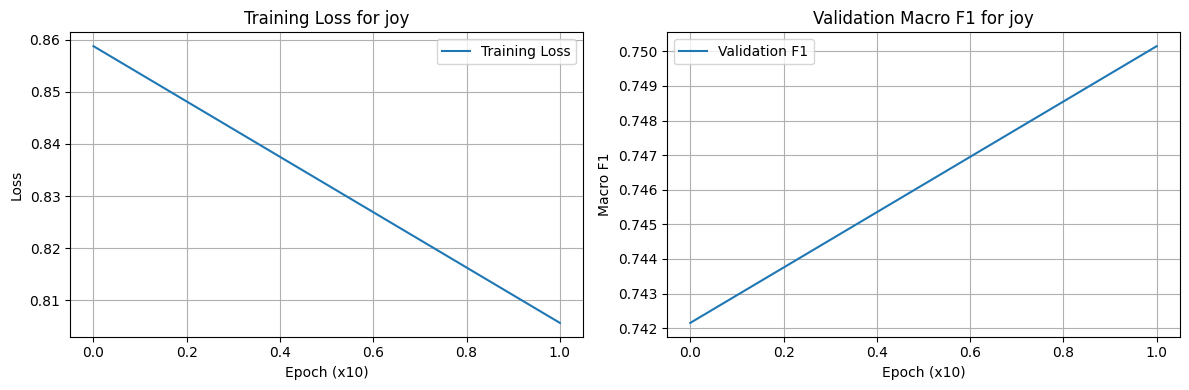

/Users/angwang/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Training model for sadness
Validation features shape for sadness: torch.Size([116, 5])


Training Loop (sadness):   0%|          | 1/401 [00:00<01:12,  5.55it/s]


Epoch 0 (sadness):
Training Loss: 0.8315, Validation Loss: 0.6951
Macro F1: 0.7799

New best model for sadness at epoch 0 with F1: 0.7799


Training Loop (sadness):   2%|▏         | 10/401 [00:01<01:04,  6.04it/s]
/var/folders/sx/hkqgssrx0jd_jb2_792hz_hm0000gp/T/ipykernel_35135/3776244651.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related t


Epoch 10 (sadness):
Training Loss: 0.7997, Validation Loss: 0.6865
Macro F1: 0.7570

Early stopping triggered at epoch 10

Loaded best model for sadness from epoch 0 with F1: 0.7799


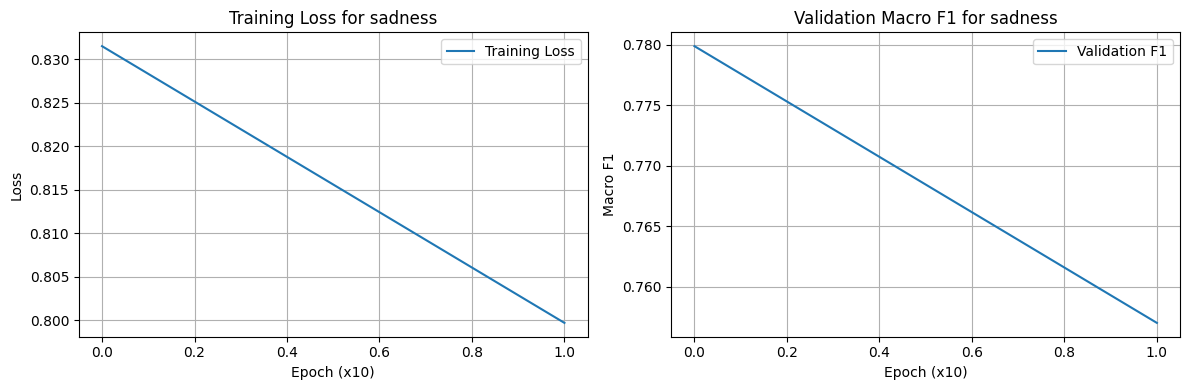

/Users/angwang/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Training model for surprise
Validation features shape for surprise: torch.Size([116, 5])


Training Loop (surprise):   0%|          | 1/401 [00:00<00:56,  7.14it/s]


Epoch 0 (surprise):
Training Loss: 0.9329, Validation Loss: 0.8339
Macro F1: 0.6523

New best model for surprise at epoch 0 with F1: 0.6523


Training Loop (surprise):   1%|          | 5/401 [00:00<00:47,  8.28it/s]


New best model for surprise at epoch 3 with F1: 0.6987


Training Loop (surprise):   3%|▎         | 12/401 [00:01<00:47,  8.13it/s]


Epoch 10 (surprise):
Training Loss: 0.8910, Validation Loss: 0.8015
Macro F1: 0.6081


Training Loop (surprise):   3%|▎         | 13/401 [00:01<00:52,  7.43it/s]
/var/folders/sx/hkqgssrx0jd_jb2_792hz_hm0000gp/T/ipykernel_35135/3776244651.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related 


Early stopping triggered at epoch 13

Loaded best model for surprise from epoch 3 with F1: 0.6987


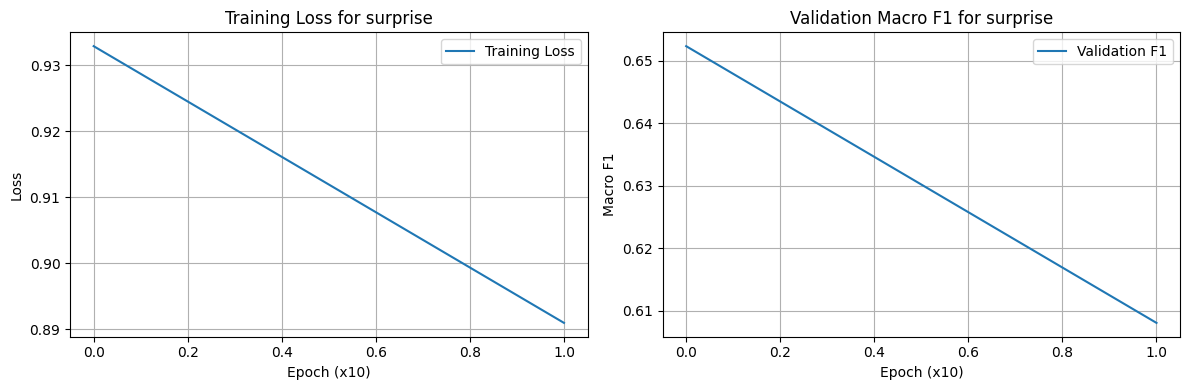

/Users/angwang/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Training model for fear
Validation features shape for fear: torch.Size([116, 5])


Training Loop (fear):   0%|          | 1/401 [00:00<00:56,  7.10it/s]


Epoch 0 (fear):
Training Loss: 0.5177, Validation Loss: 0.5893
Macro F1: 0.5643

New best model for fear at epoch 0 with F1: 0.5643


Training Loop (fear):   0%|          | 2/401 [00:00<01:09,  5.78it/s]


New best model for fear at epoch 1 with F1: 0.5857


Training Loop (fear):   1%|          | 3/401 [00:00<01:10,  5.65it/s]


New best model for fear at epoch 2 with F1: 0.6340


Training Loop (fear):   1%|          | 4/401 [00:00<01:34,  4.18it/s]


New best model for fear at epoch 3 with F1: 0.6433


Training Loop (fear):   1%|          | 5/401 [00:01<01:38,  4.02it/s]


New best model for fear at epoch 4 with F1: 0.6564


Training Loop (fear):   3%|▎         | 12/401 [00:02<01:10,  5.56it/s]


Epoch 10 (fear):
Training Loss: 0.4861, Validation Loss: 0.5781
Macro F1: 0.6091


Training Loop (fear):   3%|▎         | 14/401 [00:02<01:20,  4.82it/s]
/var/folders/sx/hkqgssrx0jd_jb2_792hz_hm0000gp/T/ipykernel_35135/3776244651.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to t


Early stopping triggered at epoch 14

Loaded best model for fear from epoch 4 with F1: 0.6564


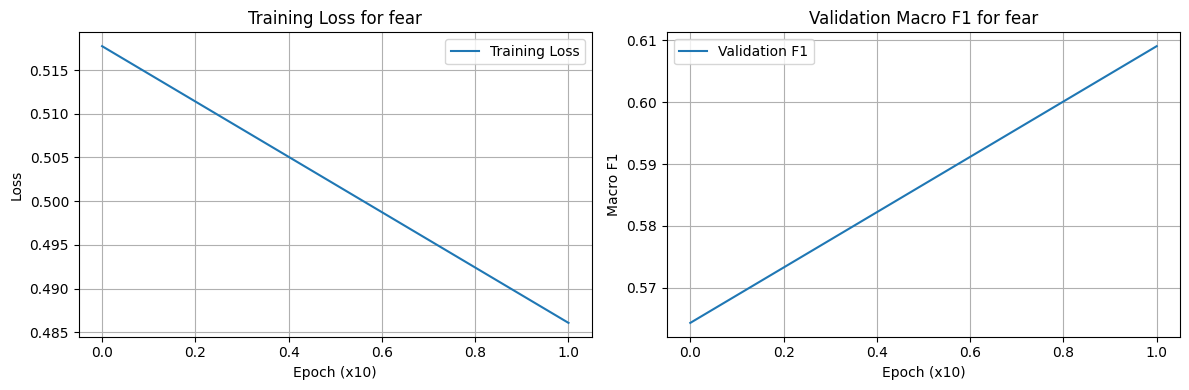

/Users/angwang/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Training model for anger
Validation features shape for anger: torch.Size([116, 5])


Training Loop (anger):   0%|          | 1/401 [00:00<01:05,  6.09it/s]


Epoch 0 (anger):
Training Loss: 1.0631, Validation Loss: 0.9931
Macro F1: 0.6829

New best model for anger at epoch 0 with F1: 0.6829


Training Loop (anger):   1%|          | 4/401 [00:00<01:09,  5.73it/s]


New best model for anger at epoch 2 with F1: 0.7186


Training Loop (anger):   3%|▎         | 12/401 [00:02<01:03,  6.17it/s]


Epoch 10 (anger):
Training Loss: 0.9660, Validation Loss: 0.9568
Macro F1: 0.5685


Training Loop (anger):   3%|▎         | 12/401 [00:02<01:10,  5.52it/s]
/var/folders/sx/hkqgssrx0jd_jb2_792hz_hm0000gp/T/ipykernel_35135/3776244651.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to 


Early stopping triggered at epoch 12

Loaded best model for anger from epoch 2 with F1: 0.7186


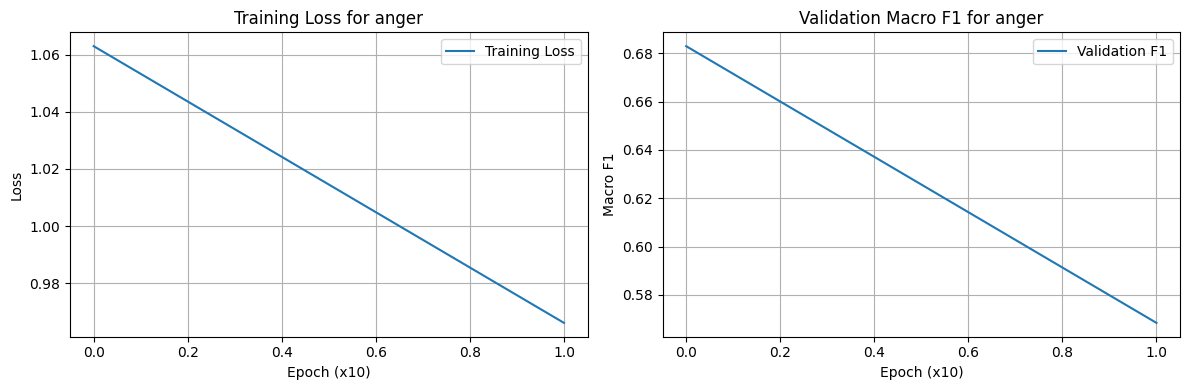

In [97]:
# Ensure all data is numeric before converting to a tensor
# final_train_features[emotion] = final_train_features[emotion].astype(float)

# Training loop for each emotion
# Training loop for each emotion
for emotion in emotions:
    print(f"\nTraining model for {emotion}")
    model = models[emotion]
    model.train()  # Add this to explicitly set training mode
    
    # Prepare data for this emotion--
    features_tensor = torch.tensor(all_train_bert_features[emotion], dtype=torch.float32)
    labels_tensor = torch.tensor(y_train[:, emotions.index(emotion)], dtype=torch.float32).unsqueeze(1)
    
    # Check if features_tensor is empty
    if features_tensor.size(1) == 0:
        print(f"Warning: No features available for {emotion}. Skipping training.")
        continue
    
    # Add validation tensors
    val_features_tensor = torch.tensor(all_val_bert_features[emotion], dtype=torch.float32)
    val_labels_tensor = torch.tensor(y_val[:, emotions.index(emotion)], dtype=torch.float32).unsqueeze(1)
    print(f"Validation features shape for {emotion}: {val_features_tensor.shape}")
    
    
    dataset = TensorDataset(features_tensor, labels_tensor)
    data_loader = DataLoader(dataset, batch_size=32, shuffle=True)  # Increased batch size

    # Calculate class weights for this emotion
    pos_weight = (len(labels_tensor) - labels_tensor.sum()) / labels_tensor.sum()
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)  # Better handling of class imbalance
    
    # Use Adam optimizer with learning rate scheduler
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.5, verbose=True)

    # Training loop
    best_f1 = 0
    patience = 10
    patience_counter = 0
    train_losses = []
    val_f1s = []
    
    for epoch in tqdm(range(401), desc=f"Training Loop ({emotion})"):
        # Training phase
        model.train()
        epoch_loss = 0
        batch_count = 0
        
        for features, labels in data_loader:
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            batch_count += 1

        avg_train_loss = epoch_loss / batch_count
        
        # Validation phase
        model.eval()
        with torch.no_grad():
            val_outputs = model(val_features_tensor)
            val_preds = (torch.sigmoid(val_outputs).squeeze() > 0.5).float()
            val_labels = val_labels_tensor.squeeze()
            
            # Calculate metrics
            val_loss = criterion(val_outputs, val_labels_tensor)
            macro_f1 = f1_score(
                val_labels.cpu().numpy(),
                val_preds.cpu().numpy(),
                average='macro',
                zero_division=0
            )

        # Learning rate scheduling
        scheduler.step(macro_f1)

        if epoch % 10 == 0:  # More frequent logging
            print(f'\nEpoch {epoch} ({emotion}):')
            print(f'Training Loss: {avg_train_loss:.4f}, Validation Loss: {val_loss:.4f}')
            print(f'Macro F1: {macro_f1:.4f}')
            train_losses.append(avg_train_loss)
            val_f1s.append(macro_f1)
        
        # Save best model
        if macro_f1 > best_f1:
            best_f1 = macro_f1
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_train_loss,
                'f1': macro_f1
            }, f'./model_checkpoints/{emotion}_best.pth')
            print(f"\nNew best model for {emotion} at epoch {epoch} with F1: {macro_f1:.4f}")
            patience_counter = 0
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered at epoch {epoch}")
            break

    # Load best model for this emotion
    checkpoint = torch.load(f'./model_checkpoints/{emotion}_best.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"\nLoaded best model for {emotion} from epoch {checkpoint['epoch']} with F1: {checkpoint['f1']:.4f}")

    # Plot training curves
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
    plt.title(f'Training Loss for {emotion}')
    plt.xlabel('Epoch (x10)')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(range(len(val_f1s)), val_f1s, label='Validation F1')
    plt.title(f'Validation Macro F1 for {emotion}')
    plt.xlabel('Epoch (x10)')
    plt.ylabel('Macro F1')
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

### Complete same training loop for all emotions using macro F1 score

In [98]:
# Save predictions
def save_predictions(predictions, ids, filename):
    df_predictions = pd.DataFrame(predictions, columns=emotions)
    df_predictions['id'] = ids
    df_predictions = df_predictions[['id'] + emotions]
    df_predictions.to_csv(filename, index=False)
    print(f"Saved predictions to {filename}")

# Save validation and test predictions
from datetime import datetime
timestamp = datetime.now().strftime('%Y-%m-%d_%H_%M_%S')

/var/folders/sx/hkqgssrx0jd_jb2_792hz_hm0000gp/T/ipykernel_35135/374312138.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f'./model_checkpoints


Generating predictions for all emotions...
Using best joy model from epoch 4 with F1: 0.776
Using best sadness model from epoch 0 with F1: 0.780
Using best surprise model from epoch 3 with F1: 0.699
Using best fear model from epoch 4 with F1: 0.656
Using best anger model from epoch 2 with F1: 0.719

Performing threshold grid search for joy...


Testing thresholds for joy: 100%|██████████| 16/16 [00:00<00:00, 303.93it/s]


Best Results for joy:
Best threshold: 0.500
Best Macro F1: 0.677


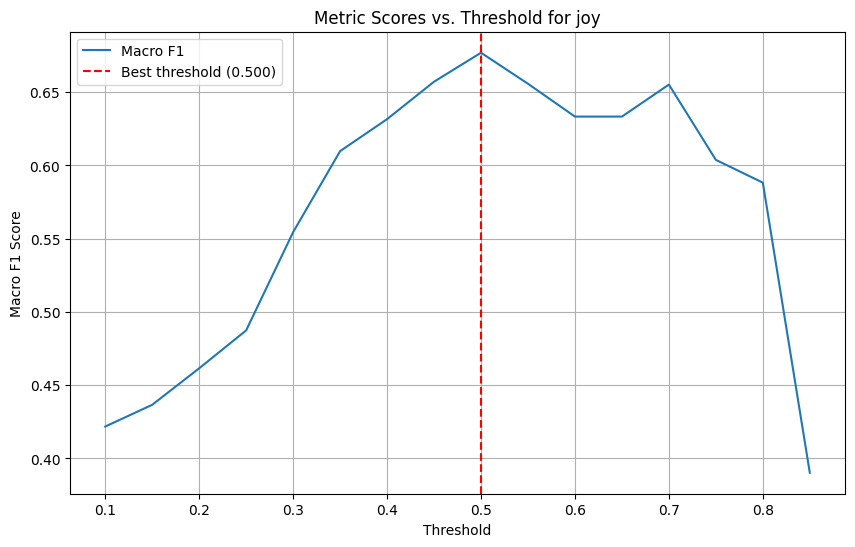


Performing threshold grid search for sadness...


Testing thresholds for sadness: 100%|██████████| 16/16 [00:00<00:00, 853.78it/s]



Best Results for sadness:
Best threshold: 0.500
Best Macro F1: 0.677


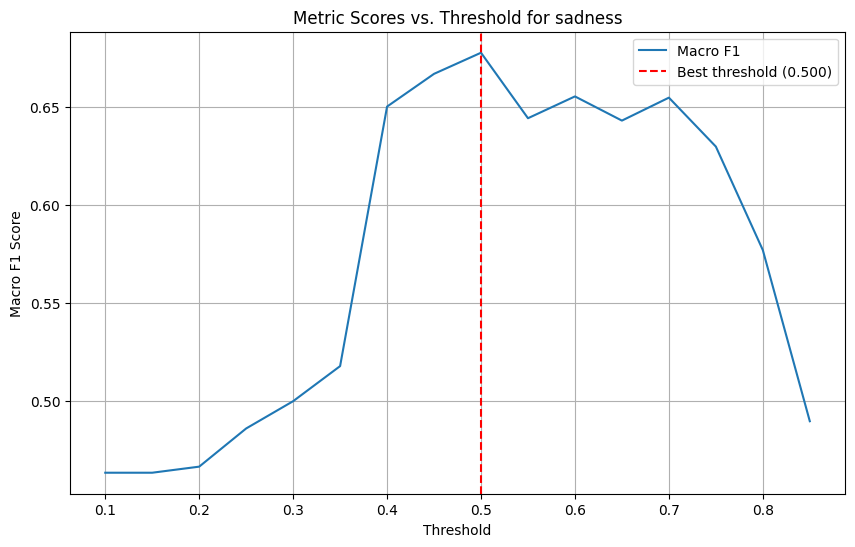


Performing threshold grid search for surprise...


Testing thresholds for surprise: 100%|██████████| 16/16 [00:00<00:00, 780.60it/s]


Best Results for surprise:
Best threshold: 0.500
Best Macro F1: 0.597


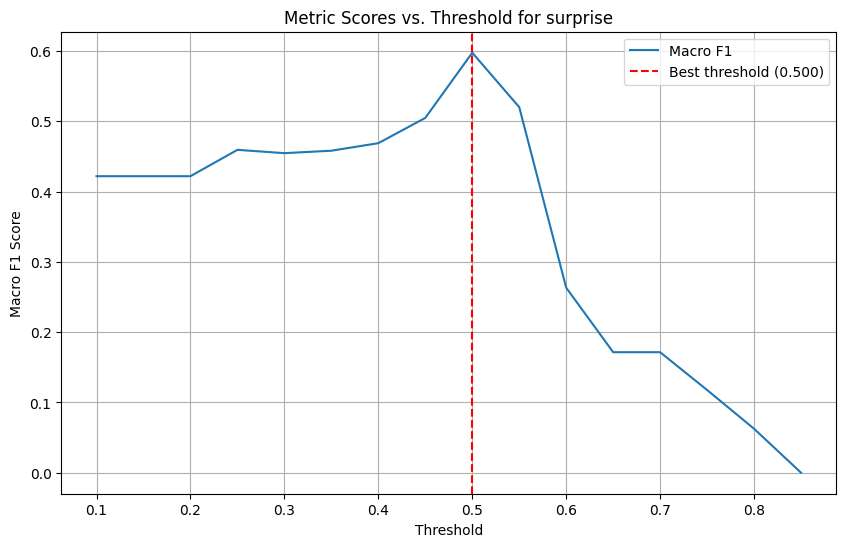


Performing threshold grid search for fear...


Testing thresholds for fear: 100%|██████████| 16/16 [00:00<00:00, 785.43it/s]


Best Results for fear:
Best threshold: 0.200
Best Macro F1: 0.717


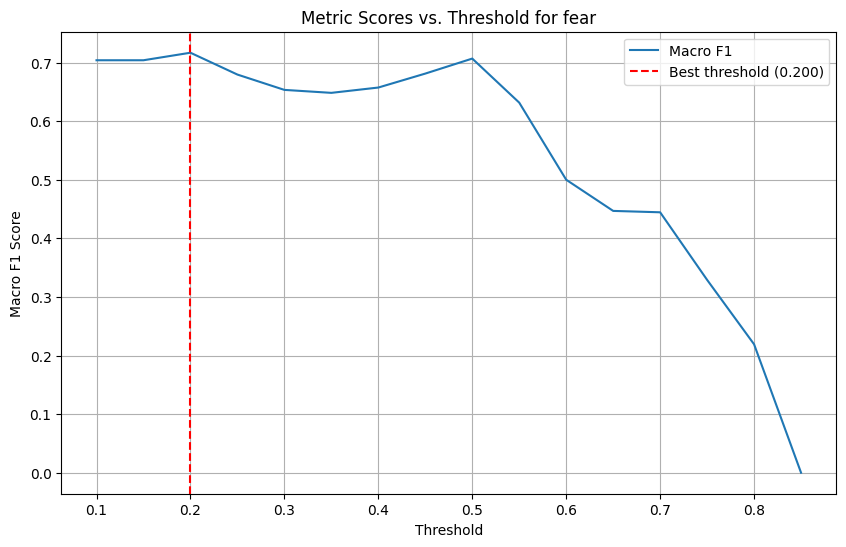


Performing threshold grid search for anger...


Testing thresholds for anger: 100%|██████████| 16/16 [00:00<00:00, 810.04it/s]


Best Results for anger:
Best threshold: 0.800
Best Macro F1: 0.606


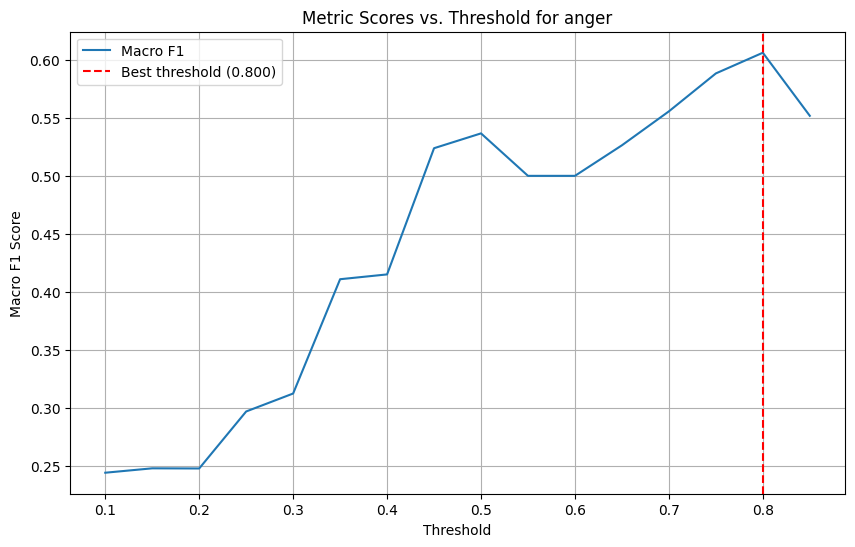


Final Validation Performance with Best Thresholds:
              precision    recall  f1-score   support

         joy       0.65      0.71      0.68        31
     sadness       0.78      0.60      0.68        35
    surprise       0.50      0.74      0.60        31
        fear       0.56      0.98      0.72        63
       anger       0.59      0.62      0.61        16

   micro avg       0.59      0.78      0.67       176
   macro avg       0.62      0.73      0.65       176
weighted avg       0.61      0.78      0.67       176
 samples avg       0.60      0.74      0.63       176

Saved predictions to ../results/val_predictions_dynamic_thresholds_2025-02-14_11_43_31.csv


/Users/angwang/miniforge3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saved predictions to ../results/test_predictions_dynamic_thresholds_2025-02-14_11_43_31.csv

Per-emotion performance at best thresholds:
joy: F1 = 0.677
sadness: F1 = 0.677
surprise: F1 = 0.597
fear: F1 = 0.717
anger: F1 = 0.606


In [100]:
# After training loop finishes for all emotions...

# Make predictions for each emotion using best models
print("\nGenerating predictions for all emotions...")
val_preds = {}
test_preds = {}

for emotion in emotions:
    # Load the best model for this emotion
    model = models[emotion]
    checkpoint = torch.load(f'./model_checkpoints/{emotion}_best.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()  # Set to evaluation mode
    
    print(f"Using best {emotion} model from epoch {checkpoint['epoch']} with F1: {checkpoint['f1']:.3f}")
    
    with torch.no_grad():
        # Get raw probabilities using sigmoid
        val_outputs = model(torch.tensor(all_val_bert_features[emotion], dtype=torch.float32))
        val_probs = torch.sigmoid(val_outputs).numpy()
        val_preds[emotion] = val_probs
        
        test_outputs = model(torch.tensor(all_test_bert_features[emotion], dtype=torch.float32))
        test_probs = torch.sigmoid(test_outputs).numpy()
        test_preds[emotion] = test_probs

# Combine predictions
val_probs = np.hstack([val_preds[emotion] for emotion in emotions])
test_probs = np.hstack([test_preds[emotion] for emotion in emotions])

# Initialize a dictionary to store the best threshold for each emotion
best_thresholds = {emotion: 0 for emotion in emotions}
best_macro_f1s = {emotion: 0 for emotion in emotions}

# Perform threshold grid search for each emotion
for i, emotion in enumerate(emotions):
    print(f"\nPerforming threshold grid search for {emotion}...")
    thresholds = np.arange(0.1, 0.9, 0.05)
    results = []

    for threshold in tqdm(thresholds, desc=f"Testing thresholds for {emotion}"):
        # Convert probabilities to binary predictions for this emotion
        val_binary_preds = (val_probs[:, i] > threshold).astype(int)
        
        # Calculate metrics
        macro_f1 = f1_score(val[emotions].values[:, i], val_binary_preds, average='binary')
        
        results.append({
            'threshold': threshold,
            'macro_f1': macro_f1
        })
        
        # Update best threshold if we found better macro F1
        if macro_f1 > best_macro_f1s[emotion]:
            best_macro_f1s[emotion] = macro_f1
            best_thresholds[emotion] = threshold

    # Convert results to DataFrame and display
    results_df = pd.DataFrame(results)
    print(f"\nBest Results for {emotion}:")
    print(f"Best threshold: {best_thresholds[emotion]:.3f}")
    print(f"Best Macro F1: {best_macro_f1s[emotion]:.3f}")

    # Plot the threshold search results for this emotion
    plt.figure(figsize=(10, 6))
    plt.plot(results_df['threshold'], results_df['macro_f1'], label='Macro F1')
    plt.axvline(x=best_thresholds[emotion], color='r', linestyle='--', label=f'Best threshold ({best_thresholds[emotion]:.3f})')
    plt.xlabel('Threshold')
    plt.ylabel('Macro F1 Score')
    plt.title(f'Metric Scores vs. Threshold for {emotion}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Generate final predictions using best thresholds for each emotion
val_binary_preds = np.zeros_like(val_probs, dtype=int)
test_binary_preds = np.zeros_like(test_probs, dtype=int)

for i, emotion in enumerate(emotions):
    val_binary_preds[:, i] = (val_probs[:, i] > best_thresholds[emotion]).astype(int)
    test_binary_preds[:, i] = (test_probs[:, i] > best_thresholds[emotion]).astype(int)

# Print detailed performance report
print("\nFinal Validation Performance with Best Thresholds:")
print(classification_report(
    val[emotions].values,
    val_binary_preds,
    target_names=emotions
))

# Save predictions
timestamp = datetime.now().strftime('%Y-%m-%d_%H_%M_%S')

# Save validation predictions
save_predictions(
    val_binary_preds,
    val['id'],
    f'../results/val_predictions_dynamic_thresholds_{timestamp}.csv'
)

# Save test predictions
save_predictions(
    test_binary_preds,
    test['id'],
    f'../results/test_predictions_dynamic_thresholds_{timestamp}.csv'
)

# Save threshold search results
results_df.to_csv(f'../results/threshold_search_results_dynamic_{timestamp}.csv', index=False)

# Print per-emotion performance
print("\nPer-emotion performance at best thresholds:")
for i, emotion in enumerate(emotions):
    emotion_f1 = f1_score(
        val[emotions].values[:, i],
        val_binary_preds[:, i],
        average='binary'
    )
    print(f"{emotion}: F1 = {emotion_f1:.3f}")

Evaluation on the Validation Set:

Evaluation scores (micro) for eng track a:
Precision: 0.5897
Recall: 0.7841
F1 score: 0.6732

Evaluation scores (macro) for eng track a:
Precision: 0.6153
Recall: 0.7321
F1 score: 0.6549

Scores for Test Set: To-be-added after Test Set gold data is released on Saturday the 15th of Feb

<!-- Evaluation scores for eng track a:

F1 score: micro=0.6199597841041379, macro=0.5523447943188394

Emotion-level macro F1 scores:
anger: 0.3597
fear: 0.7426
joy: 0.5248
sadness: 0.5489
surprise: 0.5857 -->

END FOR NOW